# Simple regression with TensorFlow

Progressive example working through various network set ups

https://towardsdatascience.com/training-neural-networks-for-price-prediction-with-tensorflow-8aafe0c55198

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [39]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.13.1


In [40]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [41]:
dat = pd.read_csv("./rbfs/phi_reduce.csv")
dat.head()
#X = np.load("./rbfs/phi_reduce.npy")
#y = np.load("./rbfs/y.npy")

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,854,855,856,857,858,859,860,y,site,date
0,0,1.000000,0.997378,0.989553,0.976648,0.958862,0.936470,0.909811,0.879282,0.845327,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014,2005,2023-01-01
1,1,1.000000,0.997433,0.989662,0.976809,0.959074,0.936729,0.910113,0.879622,0.845701,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007,2005,2023-01-01
2,2,0.999999,0.997487,0.989771,0.976971,0.959285,0.936987,0.910414,0.879962,0.846074,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002,2005,2023-01-01
3,3,0.999997,0.997541,0.989879,0.977131,0.959496,0.937245,0.910715,0.880302,0.846447,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009,2005,2023-01-01
4,4,0.999995,0.997594,0.989986,0.977291,0.959707,0.937502,0.911016,0.880641,0.846820,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011,2005,2023-01-01


In [42]:
dat2 = dat[dat['date'] == "2023-01-01"]
dat2.shape

(191, 865)

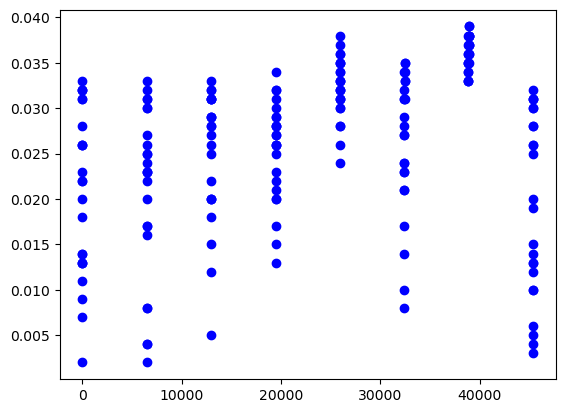

In [43]:
plt.plot(dat2['y'], 'bo')

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size = 0.8, random_state=42)

In [45]:
## Alternate for site samples
train = dat[dat.site != 2005]
print(train.shape)
X_train = train.iloc[:, 1:862]
y_train = train['y']

(45330, 865)


In [46]:
train.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,854,855,856,857,858,859,860,y,site,date
6491,6491,1.000000,0.997378,0.989553,0.976648,0.958862,0.936470,0.909811,0.879282,0.845327,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017,3006,2023-01-01
6492,6492,1.000000,0.997433,0.989662,0.976809,0.959074,0.936729,0.910113,0.879622,0.845701,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008,3006,2023-01-01
6493,6493,0.999999,0.997487,0.989771,0.976971,0.959285,0.936987,0.910414,0.879962,0.846074,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004,3006,2023-01-01
6494,6494,0.999997,0.997541,0.989879,0.977131,0.959496,0.937245,0.910715,0.880302,0.846447,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002,3006,2023-01-01
6495,6495,0.999995,0.997594,0.989986,0.977291,0.959707,0.937502,0.911016,0.880641,0.846820,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017,3006,2023-01-01


In [47]:
## Alternate for site samples
test = dat[dat.site == 2005]
print(test.shape)
X_test = test.iloc[:, 1:862]
y_test = test['y']

(6491, 865)


In [48]:
print(y_train[0:100])
print(y_test[0:100])

6491    0.017
6492    0.008
6493    0.004
6494    0.002
6495    0.017
        ...  
6586    0.018
6587    0.008
6588    0.008
6589    0.010
6590    0.016
Name: y, Length: 100, dtype: float64
0     0.014
1     0.007
2     0.002
3     0.009
4     0.011
      ...  
95    0.024
96    0.024
97    0.031
98    0.034
99    0.031
Name: y, Length: 100, dtype: float64


ValueError: x and y must have same first dimension, but have shapes (5000,) and (5001,)

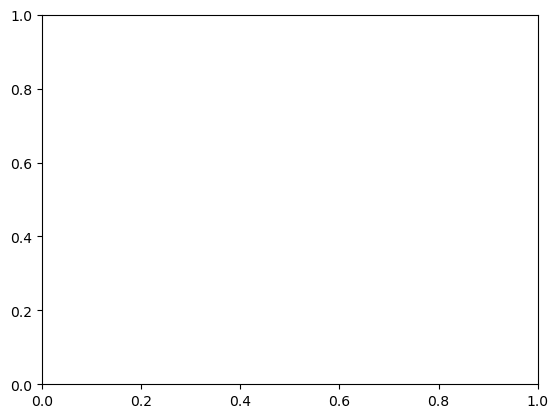

In [51]:
plt.plot(np.arange(0,5000), y_test[0:50001])
plt.plot(np.arange(0,5000), y_train[1:5000])
plt.show()


(array([2.8090e+03, 4.0340e+03, 9.2550e+03, 1.3645e+04, 1.2332e+04,
        7.3420e+03, 2.0200e+03, 3.2900e+02, 4.8000e+01, 7.0000e+00]),
 array([-0.001 ,  0.0094,  0.0198,  0.0302,  0.0406,  0.051 ,  0.0614,
         0.0718,  0.0822,  0.0926,  0.103 ]),
 <BarContainer object of 10 artists>)

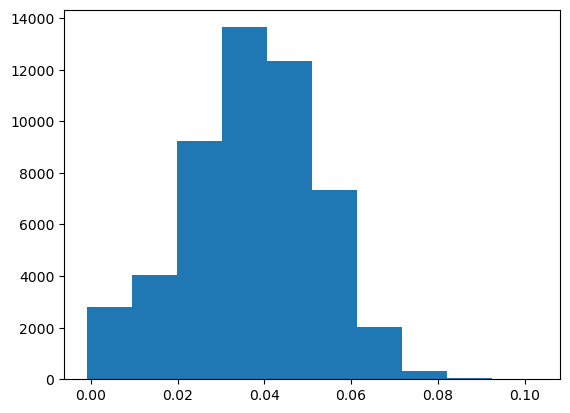

In [30]:
plt.hist(y_train)

## TensorFlow

In [ ]:
# Set random seed
tf.random.set_seed(42)
from keras import Sequential
from keras import models
from keras import layers

In [ ]:
n_feat = X_train.shape[1]

### Model 1 (Simple TF regression)

In [ ]:
model = models.Sequential([
  layers.Dense(512, activation='relu', input_shape=(n_feat,)),
  layers.Dense(512, activation='relu'),
  layers.Dense(256, activation='relu'),
  layers.Dense(256, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='linear')
], name="Initial_model")
model.summary()

In [ ]:
# Compile the model
initial_learning_rate = 0.00001
optimizer = keras.optimizers.Adam(learning_rate=initial_learning_rate)
model.compile(loss='mae', metrics=['mae', 'mse'], optimizer='adam')

In [ ]:
history=model.fit(X_train, y_train, epochs=50, 
                  batch_size=1024, verbose=1, 
                  validation_split=0.2)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
y_test_pred = model.predict(X_test)
mean_absolute_error(y_test, y_test_pred)

In [ ]:
plt.plot(y_test, y_test_pred, 'bo')

In [ ]:
plt.plot(y_test)
plt.plot(y_test_pred)
plt.show()

In [ ]:
plt.plot(y_test[0:200])
plt.plot(y_test_pred[0:200])
plt.show()

### Regularization with drop-outs

In [ ]:
model = models.Sequential([
  layers.Dense(512, activation='relu', input_shape=(n_feat,)),
  layers.Dropout(0.2),
  layers.Dense(512, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='linear')
], name="Dropout")
model.summary()

In [ ]:
# Compile the model
model.compile(loss='mae', metrics=['mae', 'mse'], optimizer='adam')

In [ ]:
history=model.fit(X_train, y_train, epochs=50, 
                  batch_size=1024, verbose=1, 
                  validation_split=0.2)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
y_test_pred = model.predict(X_test)
mean_absolute_error(y_test, y_test_pred)

In [ ]:
plt.plot(y_test)
plt.plot(y_test_pred)
plt.show()

In [ ]:
plt.plot(y_test[0:200])
plt.plot(y_test_pred[0:200])
plt.show()